# Google Drive Loading
It requires to mount the directory first
Please put the data in the same directory as below to avoid probems

In [ ]:
import numpy as np
import pickle as pk
from google.colab import drive
import tensorflow as tf
import os
# drive.mount('/content/gdrive', force_remount=True)

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
def motionLoad(classes, directory, window = 60):
  
  if directory.endswith("/"):
    dire = directory
  else:
    dire = directory+"/"
  file_list = os.listdir(dire) #returns a list containing the names of the entries in the directory given by path
#   print(file_list)
  file_list = [i for i in file_list if any(s in i for s in classes)] # get all the files in the file list 
#   print(file_list)
  instances = []
  labels = []
  #READ FILES
  for f in file_list: # for each file in the file list
    label = [0.,0.,0.]
    index = 0
    #CHECK CLASS
    for c, cla in enumerate(classes):
      if cla in f:
        label[c] = 1.0
    #OPEN FILE    
    with open(directory+f) as doc:
      lines = doc.readlines()
    end = 0
    #READ AND APPEND
    while index < len(lines):
      count = 0
      subin = []
      if index+window < len(lines):
        while count < window:
          count +=1
          out = lines[index].split("|m ")[1].split(" |class")[0].split(" ") # if you make changes look here
          out = [float(i) for i in out]
          subin.append(out)
          index +=1 # pay attention here!
        instances.append(np.array(subin))
        labels.append   (np.array(label))
      else:
        index = len(lines)
  return instances, labels
      
          
      

In [ ]:
xv, yv = motionLoad(["Crouching", "Running", "Swing"], "/content/gdrive/My Drive/Colab Notebooks/DLLab/Motion/VAL/", 60)
xtr, ytr = motionLoad(["Crouching", "Running", "Swing"], "/content/gdrive/My Drive/Colab Notebooks/DLLab/Motion/TRAIN/", 60)
xte, yte = motionLoad(["Crouching", "Running", "Swing"], "/content/gdrive/My Drive/Colab Notebooks/DLLab/Motion/TEST/", 60)
# motionLoad(["Crouching", "Running", "Swing"], "/content/gdrive/My Drive/DLLab/Motion/TEST/")

In [ ]:
xtr = np.array(xtr)
ytr = np.array(ytr)
xv = np.array(xv)
yv = np.array(yv)
xte = np.array(xte)
yte = np.array(yte)

In [ ]:
xv.shape # (BATCH, TIME, FEATURES)

(355, 60, 20)

In [ ]:
xtr.shape # (BATCH, TIME, FEATURES)

(2850, 60, 20)

In [ ]:
xte.shape

(704, 60, 20)

In [ ]:
# reshape the x data to fit it into scaler
xv = xv.reshape((-1,20))
xtr = xtr.reshape((-1,20))
xte = xte.reshape((-1,20))

In [ ]:
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#scaler = MinMaxScaler(feature_range = (0, 1))
scaler = StandardScaler()

motion_training_scaler = scaler.fit(xtr)
xtr = motion_training_scaler.transform(xtr)
xv = motion_training_scaler.transform(xv)
xte = motion_training_scaler.transform(xte)

In [ ]:
xtr = xtr.reshape((-1,60,20))
xv = xv.reshape((-1,60,20))
xte = xte.reshape((-1,60,20))

In [ ]:
from tensorflow.keras.layers import Dense, GRU, SimpleRNN, LSTM, Dropout
from tensorflow.keras import Model as Model_
from tensorflow.keras import regularizers

# define a model structure
class LSTM_Model(Model_):
  def __init__(self): 
    super(LSTM_Model, self).__init__()
    self.lstmLayer = LSTM(units=20, input_shape=(60,20))
    self.dropoutLayer = Dropout(0.2)
    
    # The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
    #self.gruLayer = GRU(256)
    # The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
    #self.rnnLayer = SimpleRNN(128)

    self.outputLayer = Dense(3, activation='softmax') 
  
  # to use the model 
  def call(self, input_x):
    output = input_x
    output = self.lstmLayer(output)
    output = self.dropoutLayer(output)
    return self.outputLayer(output)

In [ ]:
# optimizer defined with model, regularizer, minibatch, learning rate, and loss
class Optimizer:
  def __init__(self, model, mb = 128, lr = 0.001, loss = tf.keras.losses.CategoricalCrossentropy, opt=tf.keras.optimizers.Adam):
    self.model     = model
    self.loss      = loss() #tf.keras.losses.MeanSquaredError()
    self.optimizer = opt(learning_rate = lr)
    self.mb        = mb

    self.train_loss     = tf.keras.metrics.Mean(name='train_loss')
    self.train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

    self.test_loss     = tf.keras.metrics.Mean(name='test_loss')
    self.test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

  
  @tf.function
  def train_step(self, x , y):
    with tf.GradientTape() as tape: # to watch the trainable variables of model and record the operations for performing automatic differentiation
      predictions = model(x)
      loss = self.loss(y, predictions)

    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
    self.train_loss(loss)
    self.train_accuracy(y, predictions)
    return loss

  @tf.function
  def test_step(self, x , y):
    predictions = self.model(x)
    loss = self.loss(y, predictions)
    self.test_loss(loss)
    self.test_accuracy(y, predictions)

  def train (self):# for each mini batch, make predictions for train set and calculate loss (which is an average of the loss values in the batch)
    for mbX, mbY in self.train_ds:
      self.train_step(mbX, mbY)
  
  def test  (self): # for each mini batch, make predictions for test set and calculate loss (which is an average of the loss values in the batch)
    for mbX, mbY in self.test_ds:
      self.test_step(mbX, mbY)    
  
  def run   (self, dataX, dataY, testX, testY, epochs, verbose=2):
    historyTR = []
    historyTS = []
    template = '{} {}, {}: {}, {}: {}'
    # generate batches with the shuffled data from train set and from test set, respectively
    self.train_ds = tf.data.Dataset.from_tensor_slices((dataX, dataY)).batch(self.mb)
    self.test_ds  = tf.data.Dataset.from_tensor_slices((testX,testY)).batch(self.mb)
    for i in range(epochs):
      
      self.train ()
    #   print(lossTR)
      self.test  ()
      # if verbose, print loss values for each epoch
      if verbose > 0:
        print(template.format("epoch: ", i+1,
                      " TRAIN LOSS: ", self.train_loss.result(),
                      " TEST LOSS: " , self.test_loss.result()),
                      " TRAIN ACC: " , self.train_accuracy.result()*100,
                      " TEST ACC: "  , self.test_accuracy.result()*100)
      
      temp = '{}'
      # append loss values for train and test loss histories
      historyTR.append(float(temp.format(self.train_loss.result())))
      historyTS.append(float(temp.format(self.test_loss.result() )))

      # has to reset states for each epoch
      self.train_loss.reset_states()
      self.train_accuracy.reset_states()
      self.test_loss.reset_states()
      self.test_accuracy.reset_states()
    return historyTR, historyTS # train loss values and test loss values

In [ ]:
# initiate a model instance
model  = LSTM_Model()

# initiate an optimzer instance to run
opt    = Optimizer (model,  mb = 128, lr = 0.001, loss = tf.keras.losses.CategoricalCrossentropy, opt=tf.keras.optimizers.Adam)
# or just: $ opt    = Optimizer (model)

# get train and test loss values after running the optimizer
tr, ts = opt.run (xtr, ytr, xv, yv, 25, verbose=1)

epoch:  1,  TRAIN LOSS: : 1.1324223279953003,  TEST LOSS: : 1.0109256505966187  TRAIN ACC:  tf.Tensor(38.666664, shape=(), dtype=float32)  TEST ACC:  tf.Tensor(49.295773, shape=(), dtype=float32)
epoch:  2,  TRAIN LOSS: : 1.0528159141540527,  TEST LOSS: : 0.9623360633850098  TRAIN ACC:  tf.Tensor(46.245613, shape=(), dtype=float32)  TEST ACC:  tf.Tensor(58.30986, shape=(), dtype=float32)
epoch:  3,  TRAIN LOSS: : 0.9947156310081482,  TEST LOSS: : 0.9174308776855469  TRAIN ACC:  tf.Tensor(51.19298, shape=(), dtype=float32)  TEST ACC:  tf.Tensor(64.50704, shape=(), dtype=float32)
epoch:  4,  TRAIN LOSS: : 0.9430263638496399,  TEST LOSS: : 0.8725016713142395  TRAIN ACC:  tf.Tensor(55.78948, shape=(), dtype=float32)  TEST ACC:  tf.Tensor(69.57747, shape=(), dtype=float32)
epoch:  5,  TRAIN LOSS: : 0.8935367465019226,  TEST LOSS: : 0.8245013356208801  TRAIN ACC:  tf.Tensor(61.824562, shape=(), dtype=float32)  TEST ACC:  tf.Tensor(76.056335, shape=(), dtype=float32)
epoch:  6,  TRAIN LOSS: :

3.2.2


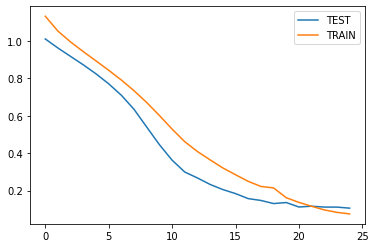

In [ ]:
# print train and test loss over epoch
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__version__)
plt.plot(ts, label='TEST')
plt.plot(tr, label='TRAIN')
plt.legend()
plt.show()

In [ ]:
# check the shape before putting it into the model
print(xtr.shape)
print(xv.shape)

(2850, 60, 20)
(355, 60, 20)


In [ ]:
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Embedding, MaxPool1D, Dense
from tensorflow.keras import Model as Model_
from tensorflow.keras import regularizers

# define a model structure
class CNN_Model(Model_):
  def __init__(self): 
    super(FCN_Model, self).__init__()
    self.conv1 = Conv1D(32, 7, activation='relu')
    self.maxpool = MaxPool1D()
    self.conv2 = Conv1D(32, 7, activation='relu')
    self.globalmaxpool = GlobalMaxPooling1D()  
    #self.dropout = Dropout(0.2)
    self.outputLayer = Dense(3, activation='softmax')

  # to use the model 
  def call(self, input_x):
    output = input_x
    output = self.conv1(output)
    output = self.maxpool(output)
    output = self.conv2(output)
    output = self.globalmaxpool(output)
    #output = self.dropoutLayer(output)
    return self.outputLayer(output)

In [ ]:
# initiate a model instance
model  = CNN_Model()

# initiate an optimzer instance to run
opt    = Optimizer (model,  mb = 128, lr = 0.001, loss = tf.keras.losses.CategoricalCrossentropy, opt=tf.keras.optimizers.Adam)
# or just: $ opt    = Optimizer (model)

# get train and test loss values after running the optimizer
tr, ts = opt.run (xtr, ytr, xv, yv, 25, verbose=1)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch:  1,  TRAIN LOSS: : 1.175915002822876,  TEST LOSS: : 0.7817130088806152  TRAIN ACC:  tf.Tensor(36.385963, shape=(), dtype=float32)  TEST ACC:  tf.Tensor(58.028168, shape=(), dtype=float32)
epoch:  2,  TRAIN LOSS: : 0.7456298470497131,  TEST LOSS: : 0.4919853210449219  TRAIN ACC:  tf.Tensor(73.08772, shape=(), dtype=float32)  TEST ACC:  tf.Tensor(89.29578, shape=(), dtype=float32)
epoch:  3,  TRAIN LOSS: : 0.48993733525276184,  TEST LOSS: : 0.3297276198863983  TRAIN ACC:  tf.Tensor(86.45614, shape=

3.2.2


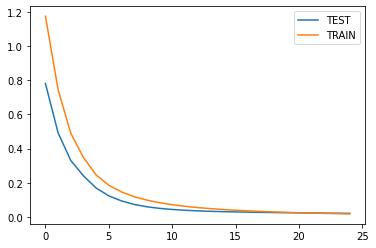

In [ ]:
# print train and test loss over epoch
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__version__)
plt.plot(ts, label='TEST')
plt.plot(tr, label='TRAIN')
plt.legend()
plt.show()